# CartPole using Policy Gradients
Based on https://medium.com/@ts1829/policy-gradient-reinforcement-learning-in-pytorch-df1383ea0baf


# Installing dependencies

In [0]:
!apt-get update
!apt-get install -y python-numpy python-dev cmake zlib1g-dev libjpeg-dev xvfb ffmpeg xorg-dev python-opengl libboost-all-dev libsdl2-dev swig
!pip install gym pyvirtualdisplay
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1710/x86_64  InRelease
Hit:2 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [83.2 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1604/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1710/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1604/x86_64  Release
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:12 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [277 kB]
Get:13 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 Packages [589 kB]
Get:14 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [13

In [0]:
!sed -i '14s/result = entry_point.load(False)/result = entry_point.resolve()/' /usr/local/lib/python3.6/dist-packages/gym/envs/registration.py

# Imports
Import libraries, Start Virtual Display and creat a CartPole Gym Environment

In [3]:
import gym
import math
import random
import numpy as np
import pandas as pd

# We will need this to visualize the simulations in the notebook
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML

# Start virtual display
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable
import torch.nn.utils as utils
from torch.distributions import Categorical

env = gym.make('CartPole-v0').unwrapped
env.seed(1)

print("Action space (discrete): {}".format( env.action_space.n))
print("Observation space (discrete): {}".format( env.observation_space))

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

Action space (discrete): 2
Observation space (discrete): Box(4,)
cuda


# **Gym CartPole environment constants and methods**
    
    Init, Seed, Step, Reset, Render, Close

*  Render modes 'human' or 'rgb_array'
*   video 50 frames per second
    0.02 seconds between states update
*  x_threshold =2.4
*  screen_width = 600 pixels
*  screen_height = 400 pixels
*  world_width = 2* x_threshold
*  scale = screen_width / world_width (600/4.8 = 125)
*  cartwidth = 50 pixels
*  cartheight = 30 pixels
*  carty = 100 (top of the cart, cart does not move on vertical axes)
*  polewidth = 10 pixels
*  polelen = scale * 2 * 0.5 = 125 pixels

These are the state variables, how the agent will see the environment. The observation_space.
   

*    x is cart center position  = env.state[0]
*   x_dot is the cart center velocity = env.state[1]
*   theta is the angle of pole with respect to vertical = env.state[2]
*   theta_dot is the velocity of the edge of the pole = env.state[3]

The states are updated using euler kinematics integrator

# MLP Case
Trying to solve using Gradient Policy without image first.
This simple NeuronNetwork will provide with Softmax  the probabilities of choose left or right based on the state provided as input.

In [0]:


#Hyperparameters
learning_rate = 0.01
gamma = 0.99


In [0]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.state_space = env.observation_space.shape[0]
        self.action_space = env.action_space.n
        
        self.l1 = nn.Linear(self.state_space, 128, bias=False)
        self.l2 = nn.Linear(128, self.action_space, bias=False)
        
        self.gamma = gamma
        
        # Episode policy and reward history 
        self.policy_history = Variable(torch.Tensor()) 
        self.reward_episode = []
        # Overall reward and loss history
        self.reward_history = []
        self.loss_history = []
   
    def forward(self, x):    
        model = torch.nn.Sequential(
            self.l1,
            nn.Dropout(p=0.6),
            nn.ReLU(),
            self.l2,
            nn.Softmax(dim=-1)
        )
        return model(x)

In [0]:
policy = SimpleNet()
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

This select_action function transforms the state array provided by gym environment to a pytorch tensor, passes it to a neural network compute through softmax a vector of two probabilities of choosing left [0] or right [1]. This select_action function then pass this vector of two probabilities to a pytorch Class who will generate a categorical distribution based on these probabilities and then sample based on multinomial pytorch class an action. It logs a history also.

In [0]:
def select_action(state):
    #Select an action (0 or 1) by running policy model and choosing based on the probabilities in state
    state = torch.from_numpy(state).type(torch.FloatTensor)
    state = policy(Variable(state))
    c = Categorical(state)
    action = c.sample()
    
    # Add log probability of our chosen action to our history    
    if len(policy.policy_history) > 0:
        policy.policy_history = torch.cat([policy.policy_history, c.log_prob(action).reshape(1)])
    else:
        policy.policy_history = c.log_prob(action).reshape(1)
    return action
  

This update_policy function computes rewards running backward direction the reward_episode vector discounting future rewards using gamma, then should scale the rewards (Normalize) but it is not working yet. Compute a loss using the rewards and the policy_history (it is gradient ascent so it wants to maximize the rewards that is why -1 signal). These weights points to where the reward will be maxmized.

In [0]:
def update_policy():
    R = 0
    rewards = []
    
    # Discount future rewards back to the present using gamma
    for r in policy.reward_episode[::-1]:
        assert(r == 1.0)
        R = r + policy.gamma * R
        rewards.insert(0,R)
        
    # Scale rewards  - Normalization
    rewards = torch.FloatTensor(rewards)
    #rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)
    
    # Calculate loss
    loss = (torch.sum(torch.mul(policy.policy_history, rewards).mul(-1), -1))
    
    # Update network weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #Save and intialize episode history counters
    policy.loss_history.append(loss.data[0])
    policy.reward_history.append(np.sum(policy.reward_episode))
    policy.policy_history = torch.Tensor()
    policy.reward_episode= []

# The training loop
Here we run an entire episode storing it rewards on reward_episode, starting with the state provided on the reset method and updating this state wih step method using the action provided by the neural network. At the end of each episode we update the policy and check if the gym environment threshold was reached (it is solved when the average reward is greater than or equal to 195.0 over 100 consecutive trials).

In [0]:
def main(episodes):
    running_reward = 10
    for episode in range(episodes):
        state = env.reset() # Reset environment and record the starting state
        done = False       
    
        for time in range(1000):
            action = select_action(state)
            # Step through environment using chosen action
            state, reward, done, _ = env.step(action.unsqueeze(dim=0).numpy()[0])


            # Save reward
            policy.reward_episode.append(reward)
            if done:
                break
        
        # Used to determine when the environment is solved.
        running_reward = (running_reward * 0.99) + (time * 0.01)

        update_policy()

        if episode % 50 == 0:
            print('Episode {}\tLast length: {:5d}\tAverage length: {:.2f}'.format(episode, time, running_reward))

        if running_reward > env.spec.reward_threshold:
            print("Solved! Running reward is now {} and the last episode runs to {} time steps!".format(running_reward, time))
            break


# Running 
Running on 1000 episodes, in each 50 episodes the Stats are shown

In [10]:


episodes = 1000
main(episodes)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Episode 0	Last length:    38	Average length: 10.28
Episode 50	Last length:   349	Average length: 38.58
Episode 100	Last length:   167	Average length: 92.08
Episode 150	Last length:   114	Average length: 112.89
Episode 200	Last length:    91	Average length: 135.93
Episode 250	Last length:   118	Average length: 152.93
Episode 300	Last length:   214	Average length: 194.38
Solved! Running reward is now 195.17582707018187 and the last episode runs to 274 time steps!


# Plotting the results
The reward_history from each episode is printed. The second graph contains the raw values and the first one is smoothed using rolling window. With the mean blue curve and +/- one standard deviation as edges.

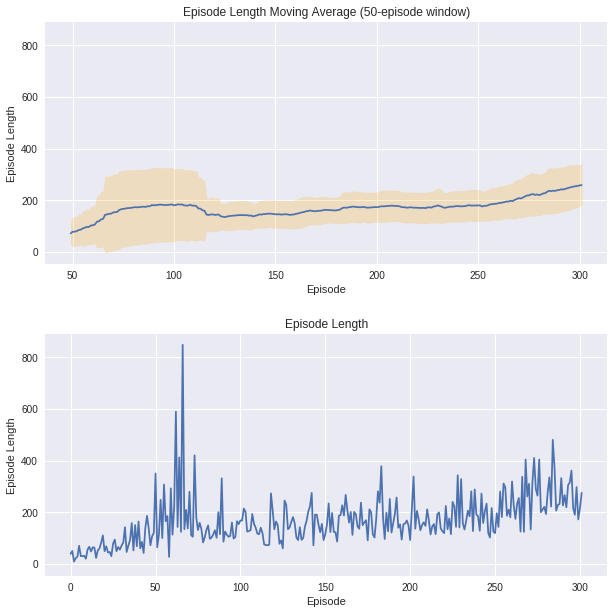

In [11]:
window = int(episodes/20)

fig, ((ax1), (ax2)) = plt.subplots(2, 1, sharey=True, figsize=[9,9]);
rolling_mean = pd.Series(policy.reward_history).rolling(window).mean()
std = pd.Series(policy.reward_history).rolling(window).std()
ax1.plot(rolling_mean)
ax1.fill_between(range(len(policy.reward_history)),rolling_mean-std, rolling_mean+std, color='orange', alpha=0.2)
ax1.set_title('Episode Length Moving Average ({}-episode window)'.format(window))
ax1.set_xlabel('Episode'); ax1.set_ylabel('Episode Length')

ax2.plot(policy.reward_history)
ax2.set_title('Episode Length')
ax2.set_xlabel('Episode'); ax2.set_ylabel('Episode Length')

fig.tight_layout(pad=2)
plt.show()
#fig.savefig('results.png')